In [1]:
import sys
import os
sys.path.insert(0,'../classes')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
import numpy as np

import coloredlogs

from arena import Arena
from coach import Coach
from beck.beck_game import BeckGame as Game
from beck.beck_nnet import NNetWrapper as nn
from beck.beck_players import HumanBeckPlayer
from mcts import MCTS
from utils import *
log = logging.getLogger(__name__)

from keras import backend as K

import tournament
participant_iters = tournament.participant_iters

participants_dir = '/scratch/zz737/fiar/tournaments/tournament_1' # dir for trained networks
results_dir = '/scratch/zz737/fiar/tournaments/results/tournament_3'
moves_dir = '/scratch/zz737/fiar/tournaments/tournament_3/moves/raw/'
splits_dir = '/scratch/zz737/fiar/tournaments/tournament_3/moves/splits/'

{'mcts100_cpuct1': [1, 2, 3, 4, 6, 7, 9, 11, 12, 16, 18, 21, 25, 28, 29, 30, 37, 38, 39, 45, 47], 'mcts100_cpuct2': [1, 2, 3, 4, 6, 8, 12, 14, 15, 16, 21, 22, 24, 26, 27, 30, 32, 35, 39], 'mcts100_cpuct3': [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 16, 17, 18, 20, 21, 25, 26, 28, 32, 34, 35, 36], 'mcts25_cpuct1': [1, 2, 3, 4, 9, 11, 13, 14, 16, 19, 22, 25, 28, 29, 31, 37, 39, 45, 59, 61], 'mcts50_cpuct1': [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 17, 18, 20, 21, 23, 25, 28, 29, 31, 37, 39, 41, 44, 45, 47, 48, 53], 'mcts80_cpuct1': [1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 16, 19, 20, 21, 23, 24, 28, 34, 35, 36, 40], 'mcts80_cpuct2': [1, 2, 5, 6, 8, 10, 12, 13, 15, 17, 18, 19, 22, 25, 28, 30, 31, 34, 37, 38, 39, 40, 43, 45, 46, 51], 'mcts80_cpuct3': [1, 2, 5, 6, 7, 9, 12, 13, 14, 19, 21, 22, 23, 24, 26, 27, 28, 35, 36, 42, 43, 47, 49, 50, 51, 53, 54, 55, 56, 57]}
189 participant iterations!


In [2]:
def read_one_subject(sub_dir,params_names=None,name='_'):
    if params_names is None:
        params_names = ['pruning_thresh','stop_p','feat_drop','lapse','active_passive','center','two_con','two_uncon','three','four','lltest']
    params_l = []
    for i in range(1,6):
        fn = sub_dir+'params'+str(i)+'.csv'
        try:
            params = np.loadtxt(fn,delimiter=',')
            ll_fn = sub_dir+f'lltest{i}.csv'
            ll = np.mean(np.loadtxt(ll_fn))
            params=np.append(params,ll)

            params_l.append(params)
        except:
            pass
        
    params_l = np.vstack(params_l)
    params_df = pd.DataFrame(params_l,columns=params_names)
    
    if 'mcts' in name:
        subname, iter = name.split(';')
        iter = int(iter)        
        mcts = int(subname.split('_')[0][4:])
        cpuct = int(subname.split('_')[1][5:])

    
        
        params_df['mcts'] = mcts
        params_df['cpuct'] = cpuct
        params_df['iter'] = iter
    
    params_names.extend(['mcts','cpuct','iter'])
    params_df = params_df.reindex(params_names,axis=1)
    
#     if isdepth:
#         subj_index = int(sub_dir.split('/')[-1])
    
#     params_df.loc[:,'mcts':'iter'] = params_df.loc[:,'mcts':'iter'].astype('int16')
    
    return params_df

def get_subject_name(sub_dir):
    fn = sub_dir+'1.csv'
    moves = np.loadtxt(fn,delimiter=',', dtype='str')
    name = moves[0].split('\t')[-2]
    return name

def read_all_subjects(splits_dir,params_names=None):
    params_all_subj_dict = {}
    for sub_dir in os.listdir(splits_dir):
        sub_dir = splits_dir + sub_dir + '/'
        name = get_subject_name(sub_dir)
        
        params_all_subj_dict[name] = read_one_subject(sub_dir,params_names=params_names,name=name)
    params_all_subj_dict = pd.concat(params_all_subj_dict,keys=params_all_subj_dict.keys())
    
    return params_all_subj_dict
    



In [3]:
params_all_subj_dict = read_all_subjects(splits_dir,None)
params_all_nn = params_all_subj_dict.dropna()

# regression: explore network hyperparameters and training iters vs cog_model parameters
regression formula:
- param ~ C(MCTS) + C(CPUCT) + ITER

baseline: MCTS25 - CPUCT1 - ITER1
## 4, 3-in a row, regression can explain some variance, also grow with training iter; 2, too low;
## cpuct not significant; mcts effect nonmonotonic


### 4

In [6]:
import statsmodels.formula.api as smf
res = smf.ols(formula='four~C(mcts)+C(cpuct)+iter',data=params_all_nn).fit()
print(res.summary())



                            OLS Regression Results                            
Dep. Variable:                   four   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     46.90
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           2.53e-50
Time:                        11:25:04   Log-Likelihood:                -2640.0
No. Observations:                 935   AIC:                             5294.
Df Residuals:                     928   BIC:                             5328.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.9468      0.458  

### 3

In [7]:
# regression: explore network hyperparameters and training iters vs cog_model parameters
## 4, 3-in a row, regression can explain some variance, also grow with training iter; 2, too low
import statsmodels.formula.api as smf
res = smf.ols(formula='three~C(mcts)+C(cpuct)+iter',data=params_all_nn).fit()
print(res.summary())



                            OLS Regression Results                            
Dep. Variable:                  three   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     38.70
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           4.37e-42
Time:                        11:25:57   Log-Likelihood:                -2207.4
No. Observations:                 935   AIC:                             4429.
Df Residuals:                     928   BIC:                             4463.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5364      0.288  

### 2 connected
R square a lot lower

In [10]:
# regression: explore network hyperparameters and training iters vs cog_model parameters
## 4, 3-in a row, regression can explain some variance, also grow with training iter; 2, too low
import statsmodels.formula.api as smf
res = smf.ols(formula='two_con~C(mcts)+C(cpuct)+iter',data=params_all_nn).fit()
print(res.summary())



                            OLS Regression Results                            
Dep. Variable:                two_con   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.118
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           0.000434
Time:                        11:27:06   Log-Likelihood:                -1927.4
No. Observations:                 935   AIC:                             3869.
Df Residuals:                     928   BIC:                             3903.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1471      0.214  

### two unconnected
R2 even lower

In [11]:
# regression: explore network hyperparameters and training iters vs cog_model parameters
## 4, 3-in a row, regression can explain some variance, also grow with training iter; 2, too low
import statsmodels.formula.api as smf
res = smf.ols(formula='two_uncon~C(mcts)+C(cpuct)+iter',data=params_all_nn).fit()
print(res.summary())



                            OLS Regression Results                            
Dep. Variable:              two_uncon   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6208
Date:                Thu, 21 Jan 2021   Prob (F-statistic):              0.714
Time:                        11:27:55   Log-Likelihood:                -2016.9
No. Observations:                 935   AIC:                             4048.
Df Residuals:                     928   BIC:                             4082.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2948      0.235  

### pruning_thresh grows with iter, non-monotomic for mcts or cpuct

In [14]:
import statsmodels.formula.api as smf
res = smf.ols(formula='pruning_thresh~C(mcts)+C(cpuct)+iter',data=params_all_nn).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         pruning_thresh   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     40.89
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           2.56e-44
Time:                        11:33:43   Log-Likelihood:                -2397.8
No. Observations:                 935   AIC:                             4810.
Df Residuals:                     928   BIC:                             4844.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3311      0.353  

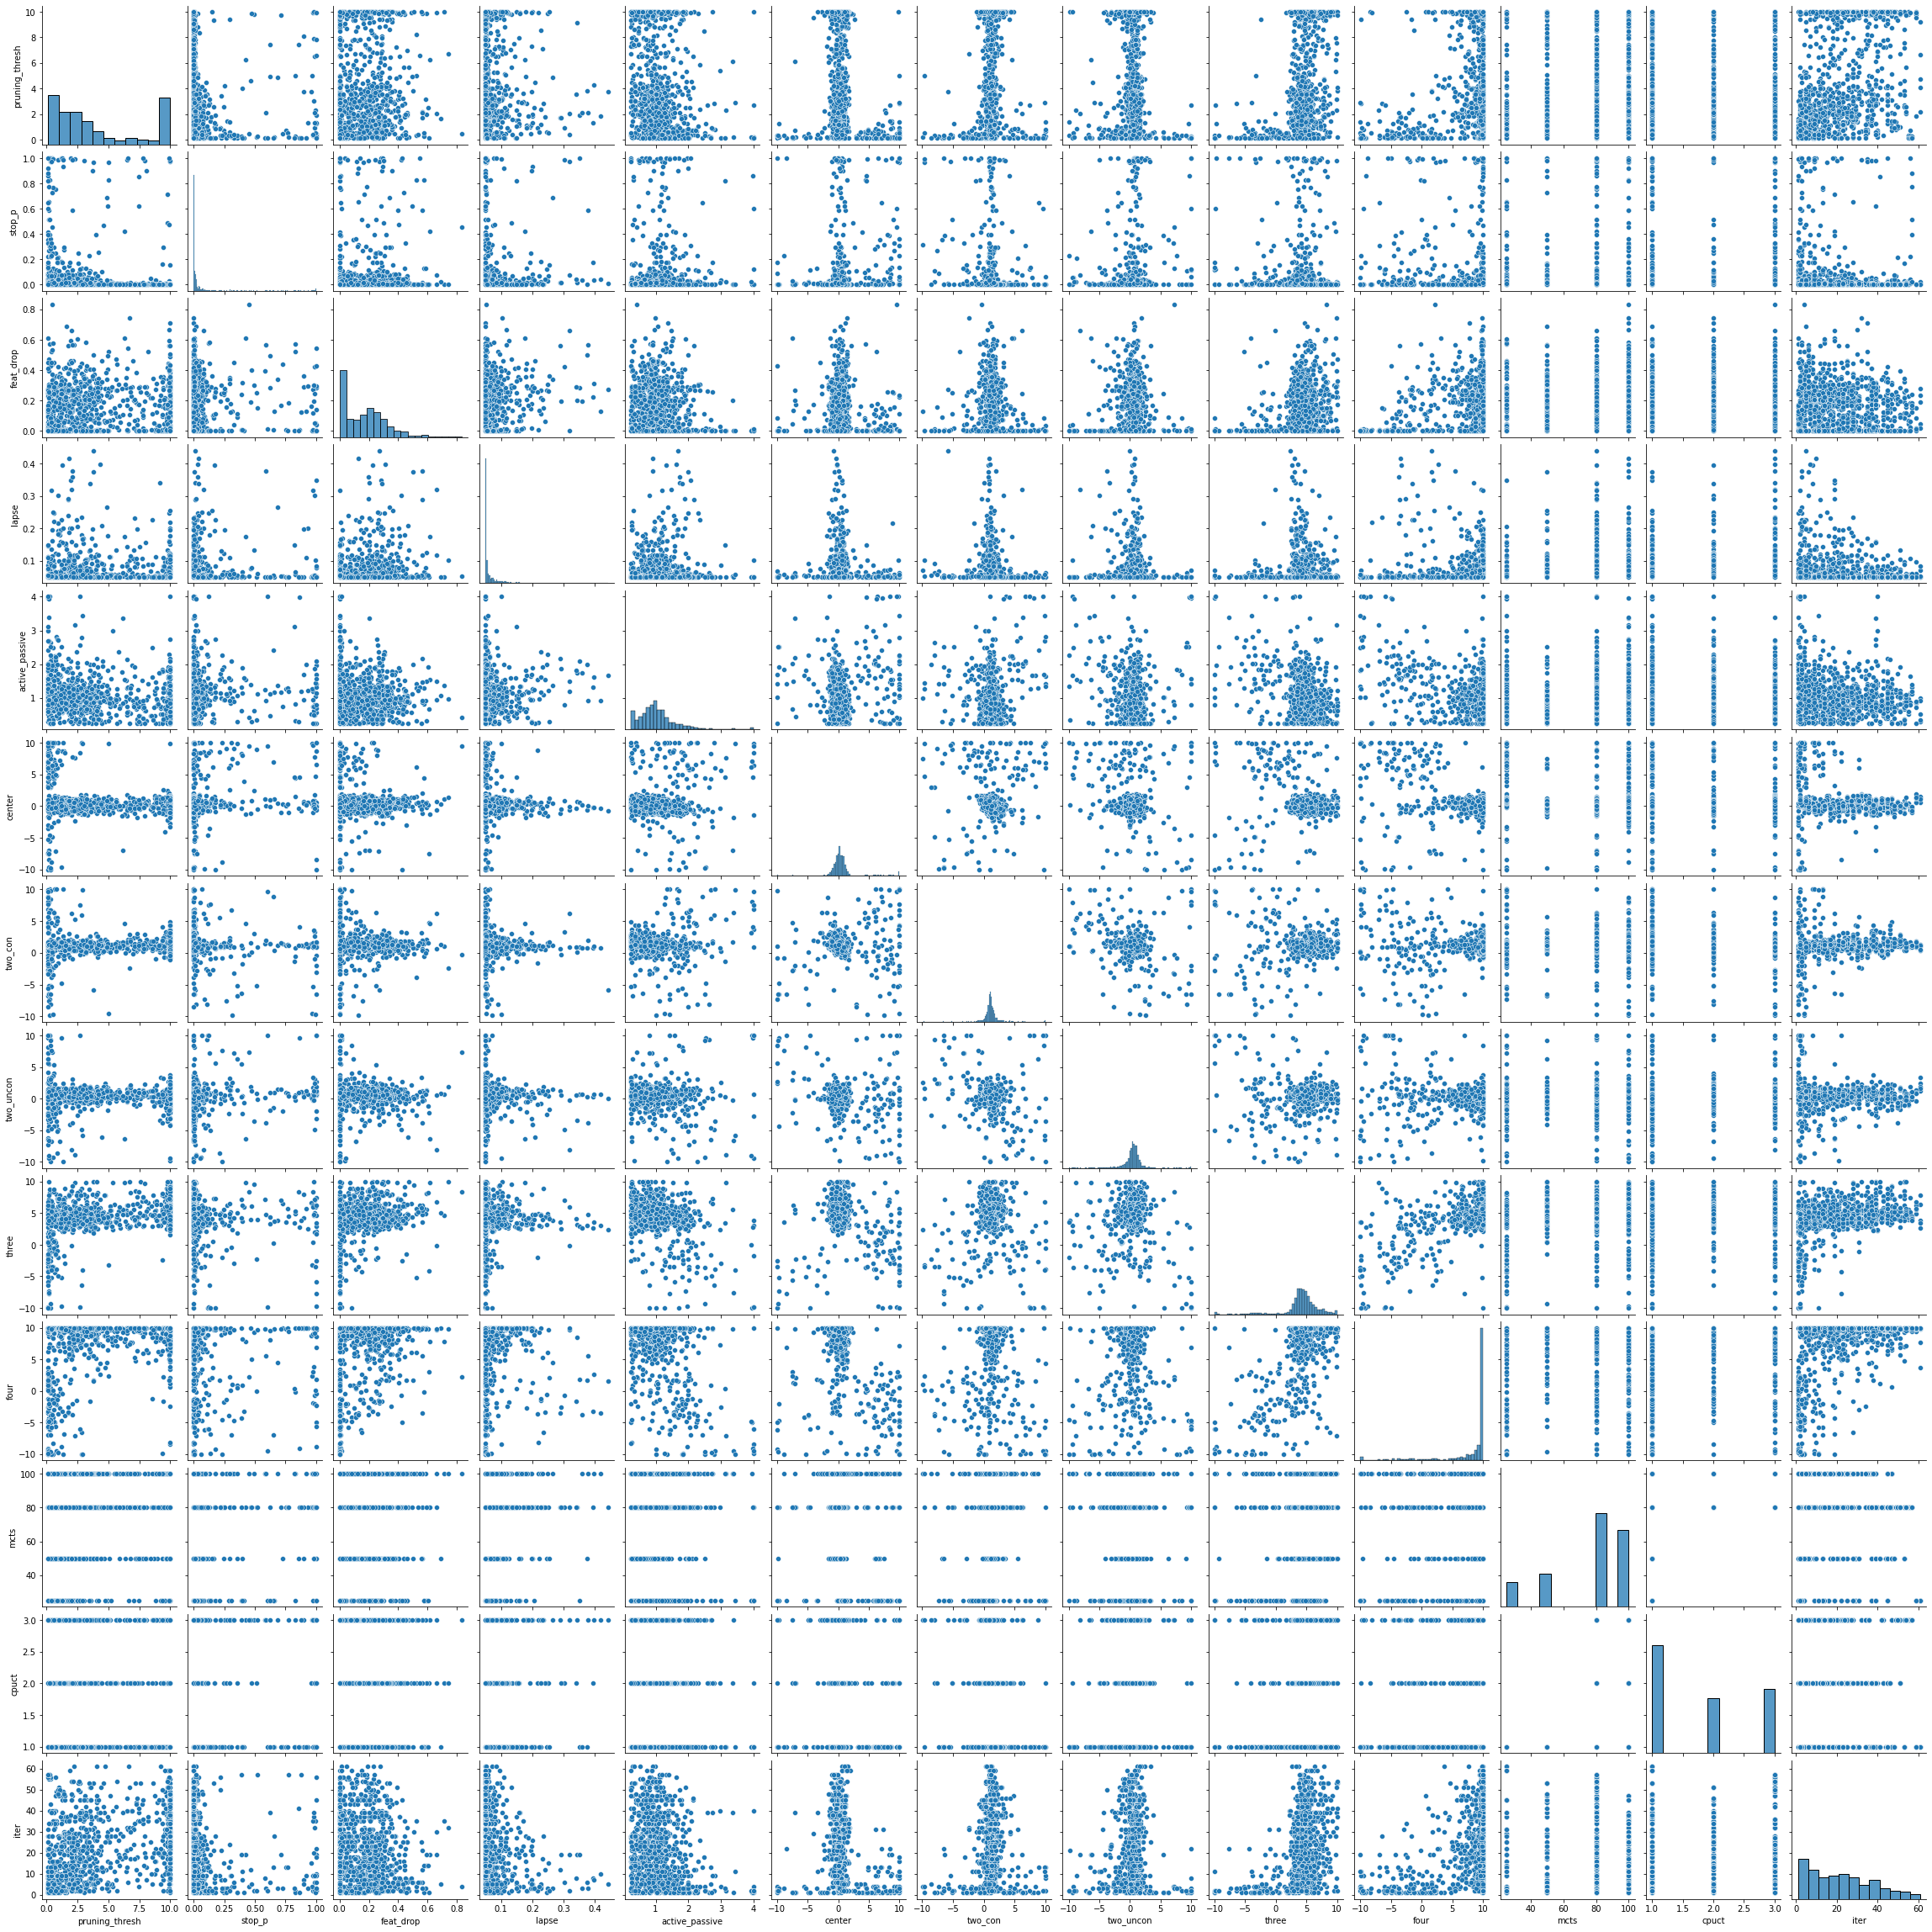

In [18]:
import seaborn as sns
sns.pairplot(params_all_nn)

### stopping probability

In [16]:
import statsmodels.formula.api as smf
res = smf.ols(formula='stop_p~C(mcts)+C(cpuct)+iter',data=params_all_nn).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                 stop_p   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     6.453
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           1.12e-06
Time:                        11:34:53   Log-Likelihood:                 176.86
No. Observations:                 935   AIC:                            -339.7
Df Residuals:                     928   BIC:                            -305.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1690      0.023  

# plot

In [9]:
def plot_one_feat_vs_iter(feat,lowess=True):
    fig = plt.figure(figsize=(5*2,4*2))
    axs=[]
    for ii,mcts in enumerate([25,50,80,100]):
        ax=fig.add_subplot(3,2,ii+1)
        ax.set_title(f'mcts = {mcts}')
        for cpuct in [1,2,3]:
            mask = (params_all_nn['mcts']==mcts)&(params_all_nn['cpuct']==cpuct)&(params_all_nn['iter']>=5)
            ax=sns.regplot(x='iter',y=feat,data=params_all_nn.loc[mask],ax=ax,label=str(cpuct),lowess=lowess)
        ax.legend(bbox_to_anchor=[1,1.05])
        axs.append(ax)
    plt.suptitle(feat)
    plt.tight_layout()

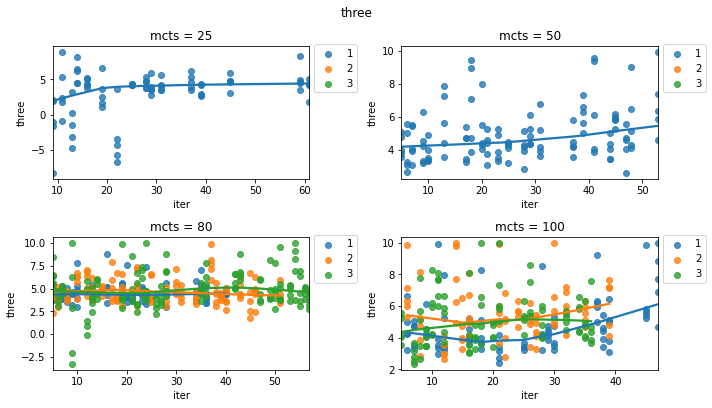

In [10]:
plot_one_feat_vs_iter('three')

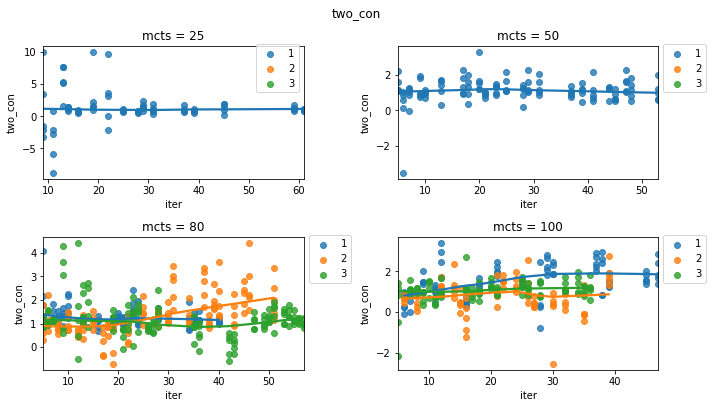

In [11]:
plot_one_feat_vs_iter('two_con')

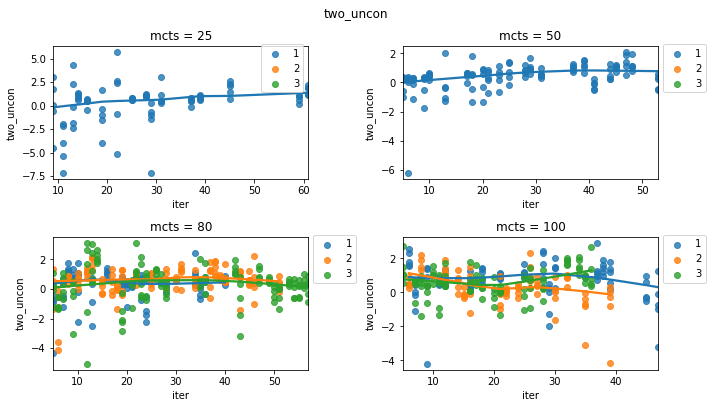

In [12]:
plot_one_feat_vs_iter('two_uncon')

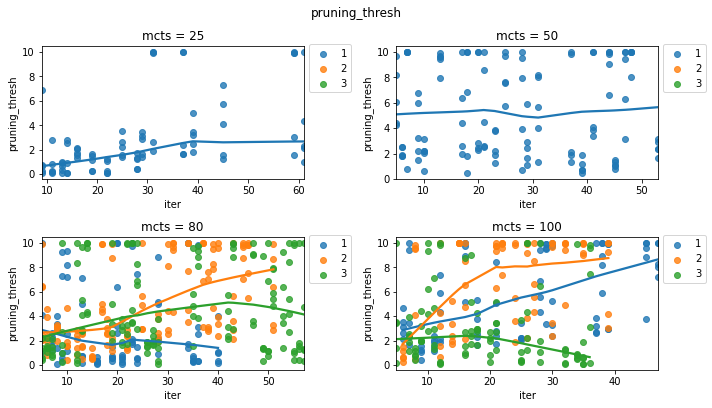

In [13]:
plot_one_feat_vs_iter('pruning_thresh')

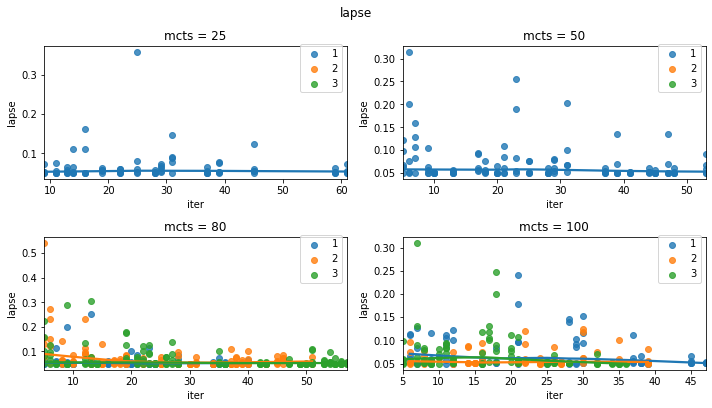

In [14]:
plot_one_feat_vs_iter('lapse')

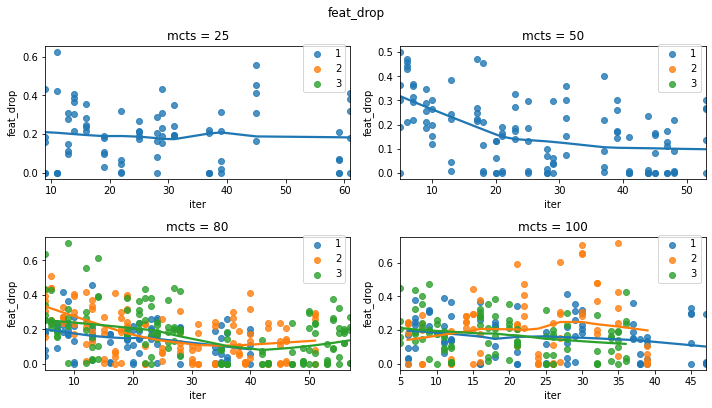

In [15]:
plot_one_feat_vs_iter('feat_drop')

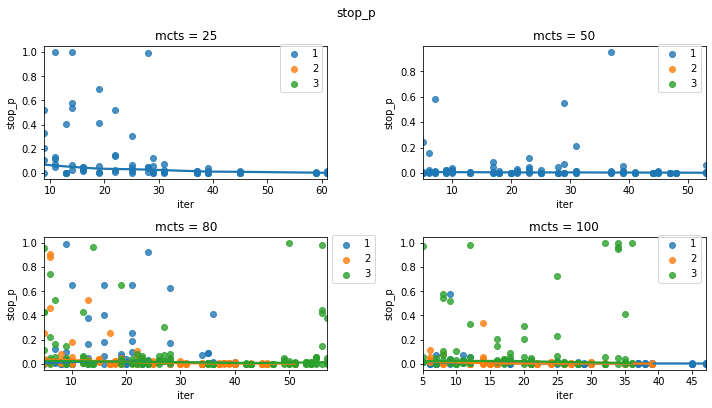

In [16]:
plot_one_feat_vs_iter('stop_p')

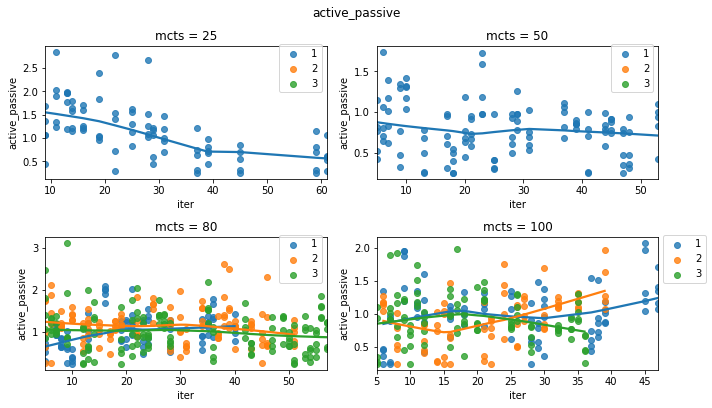

In [17]:
plot_one_feat_vs_iter('active_passive')

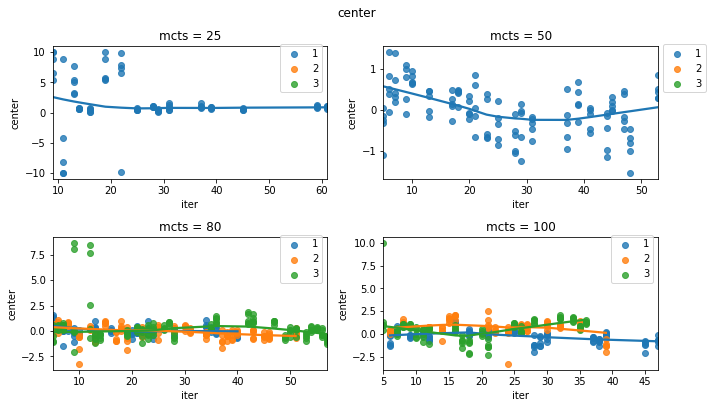

In [18]:
plot_one_feat_vs_iter('center')

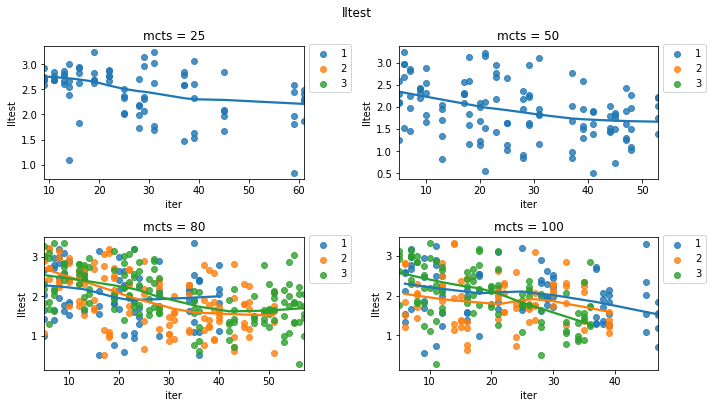

In [20]:
plot_one_feat_vs_iter('lltest')